# **Capstone Project: Air Pollution Agent Robert**

Project link to my Github: 

Have you ever had any troubles knowing the Air Quality Index (AQI) of your area? Or do you need advice on how to prepare yourself from the air pollution? No worries! Air pollution agent, Robert will provide you the latest updates on air pollution and also giving you advice on everything about air pollution.

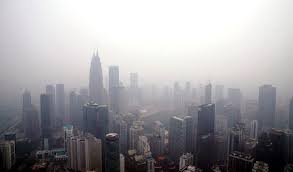
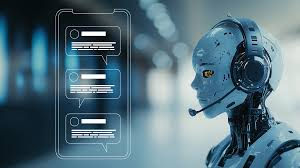
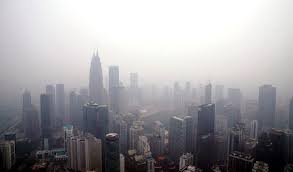
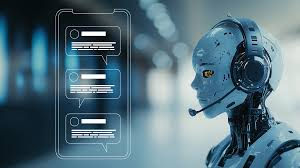

# **Setup**

All the setup packages required for building the agent:

In [44]:
!pip install --quiet pymupdf
!pip install --quiet python-docx
!pip install -U -q "google-genai==1.9.0"
!pip install -qU 'langchain-google-genai==2.1.2'

In [45]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display, Image

genai.__version__

'1.9.0'

In [6]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

In [7]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import sqlite3
import fitz  # PyMuPDF for PDFs
import PIL
from docx import Document
from datetime import datetime
from PIL import Image
from IPython.display import display, Markdown
from langchain.tools import Tool

# **Few shot prompt**

This few shot prompt is used so that the agent is able to learn and able to provide the correct answers regarding air pollution. It is to test whether the model used can learn the examples well and answer the following questions correctly.

In [9]:
few_shot_prompt_airPollution="""
    Generates a descriptive visual prompt based on the given Air Quality Index (AQI).

    Args:
        aqi (int): The Air Quality Index value.

    Returns:
        str: A textual description representing what the environment might look like 
             at the specified AQI level. Useful for generating or interpreting images 
             related to air pollution levels.
    
    if aqi < 50:
        return "Clear sky over a clean, green city with visible skyline and parks."
    elif aqi < 100:
        return "A moderately hazy city with light pollution visible in the atmosphere."
    elif aqi < 200:
        return "City under a noticeable haze with a yellowish sky and low visibility."
    else:
        return "Heavily polluted urban area with smog, dark skies, and face-mask-wearing people."
    """

user_prompt = "Describe the scene in Penang where aqi is 75."

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt_airPollution, user_prompt])

display(Markdown(f"{response.text}"))    

A moderately hazy view of Georgetown, Penang. The iconic Komtar tower is visible but slightly blurred in the distance. Light pollution creates a subtle glow in the atmosphere above the city, obscuring some of the stars. The Penang Bridge stretches across the water, its details softened by the haze.


# **GenAI Evaluation**

In this section, we evaluated the performance of the model used before we proceed with the agent building. This can be done by building a latency and respond function of the model so that it shows how accurately the model got the city matched with the data provided. Then, it also prints out the latency of the model to show the efficiency of the model in answering the questions.

First, we load up the dataset:

In [10]:
df = pd.read_csv('/kaggle/input/world-air-quality-data-2024-updated/world_air_quality.csv',sep=';')
df.dropna(inplace=True)

#Remove extra spaces
df.columns = df.columns.str.strip()
df.head()

,Country Code,City,Location,Coordinates,Pollutant,Source Name,Unit,Value,Last Updated,Country Label
195,LA,Bueng Kan,Bueng Kan District Office,"18.358249, 103.652055",CO,Air4Thai,ppm,2.670,2023-06-13T05:30:00+05:30,Lao People's Dem. Rep.
196,LT,Integrated Monitoring Network,NET-LT002A,"55.46333312949894, 26.004169460000004",PM2.5,EEA Lithuania,µg/m³,2.200,2024-03-11T16:30:00+05:30,Lithuania
197,LT,National Air Monitoring Network,NET-LT001A,"55.68999999950047, 21.17946",CO,EEA Lithuania,µg/m³,209.556,2024-03-11T16:30:00+05:30,Lithuania
198,LU,Air Quality Luxembourg,NET-LU005A,"49.61156999947028, 6.118470000000001",NO2,EEA Luxemburg,µg/m³,10.700,2024-03-11T17:30:00+05:30,Luxembourg
199,LU,Air Quality Luxembourg,NET-LU005A,"49.505039999469965, 5.97694",PM2.5,EEA Luxemburg,µg/m³,8.000,2024-03-11T17:30:00+05:30,Luxembourg


In [11]:
def measure_latency_and_respond(model_function, *args, **kwargs):
    start_time = time.time()
    response = model_function(*args, **kwargs)
    latency = time.time() - start_time
    return response, latency

In [12]:
def evaluate_response(user_query: str, model_response: str, expected_keywords: list, source_df: pd.DataFrame, latency: float, city_col='City') -> dict:
    """
    Evaluates GenAI responses for factual accuracy, relevance, completeness, and tracks latency.
    """
    
    # City match (simple check)
    matched_city = None
    for city in source_df[city_col].unique():
        if city.lower() in user_query.lower():
            matched_city = city
            break

    # Check if model used expected keywords
    keyword_score = sum(1 for kw in expected_keywords if kw.lower() in model_response.lower()) / len(expected_keywords)

    # Check against actual data (e.g., PM2.5 value)
    factual_score = None
    if matched_city:
        actual_row = source_df[source_df[city_col] == matched_city].iloc[0]
        pm25_actual = actual_row.get("PM2.5")
        if pd.notna(pm25_actual):
            factual_score = "PM2.5" in model_response and str(int(pm25_actual)) in model_response
        else:
            factual_score = "PM2.5" in model_response

    # Summary
    return {
        "City_detected": matched_city,
        "Keyword_coverage": f"{keyword_score*100:.0f}%",
        "Factual_match": factual_score if factual_score is not None else "N/A",
        "latency_seconds": f"{latency:.2f}s",
        "Comments": "Looks good!" if keyword_score > 0.8 and factual_score else "Needs improvement"
    }

In [15]:
response_obj, latency_result = measure_latency_and_respond(lambda: client.models.generate_content(
    model="gemini-2.0-flash",
    contents=["What is the PM2.5 level in Delhi?"],
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=1000,
    )
))

# Extract text from the response
model_answer = ""
for part in response_obj.candidates[0].content.parts:
    if part.text:
        model_answer += part.text + "\n"
model_answer = model_answer.strip()

eval_result = evaluate_response(
    user_query="What is the PM2.5 level in Delhi?", 
    model_response=model_answer,
    expected_keywords=["PM2.5", "Delhi"], 
    latency=latency_result,
    source_df=df  
)

for key, value in eval_result.items():
    print(f"{key}: {value}")

display(Markdown(model_answer))

City_detected: Delhi
Keyword_coverage: 100%
Factual_match: True
latency_seconds: 2.07s
Comments: Looks good!


I cannot give you a real-time PM2.5 level for Delhi. Air quality changes very rapidly.

However, here's how you can find the information:

*   **Reliable Air Quality Websites/Apps:**
    *   **Central Pollution Control Board (CPCB) Website:** The official source for Indian air quality data.
    *   **SAFAR-India:** (System of Air Quality and Weather Forecasting and Research) - Another Indian government initiative.
    *   **World Air Quality Index (WAQI):** A popular global site that aggregates data from various sources.
    *   **BreezoMeter:** A commercial service that provides detailed air quality information.
    *   **AirVisual:** Another popular global air quality monitoring platform.
    *   **Your Phone's Weather App:** Many weather apps now include air quality information.

**Tips for Using These Resources:**

*   **Check the Timestamp:** Make sure the data is recent (within the last hour is best).
*   **Look at Multiple Sources:** Compare readings from different sources to get a more reliable picture.
*   **Understand the AQI Scale:** Familiarize yourself with what the PM2.5 values mean in terms of health risks.

**Important Considerations:**

*   **Delhi is a large city:** Air quality can vary significantly from one neighborhood to another. Try to find a monitoring station that is close to your location.
*   **Air quality changes constantly:** Factors like traffic, weather, and industrial activity can all affect PM2.5 levels.

Well, seems like the bot is able to mention the facts and city correctly. But there seems to be some problems where the bot cannot provide real-time update or even retrieve the information from the dataset in order to provide the updates or PM2.5 levels in Delhi to user. Maybe we try to find tune and build some useful tools to our agent.

# **Understanding Documents Given by the User**

We built a function where the agent is able to read the file path prompted by the user and if the file type is a document, the agent will read the document and provide insights and suggesttion, or even summarize the documents about air pollution to the users.

In [23]:
def read_document(file_path):
    """
    Uses Gemini to analyze documents related to air pollution,
    then provide insights or suggestions, or summarize the document based on user's request.
    """
    if file_path.endswith('.txt'):
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read()
    elif file_path.endswith('.pdf'):
        doc = fitz.open(file_path)
        return "\n".join([page.get_text() for page in doc])
    elif file_path.endswith('.docx'):
        doc = Document(file_path)
        return "\n".join([para.text for para in doc.paragraphs])
    else:
        raise ValueError("Unsupported file type")

In [24]:
!wget -nv https://www.greenpeace.org/static/planet4-india-stateless/2024/03/44a856c8-2023_world_air_quality_report.pdf -O report.pdf
document_text = read_document("report.pdf")

prompt = f"""
Here is a recent report on air pollution:

{document_text[:3000]}  # Truncate if too long

Can you summarize key concerns and mention which cities are most affected?
"""
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.0,
        max_output_tokens=1000,
    ),
    contents=prompt)

display(Markdown(f"{response.text}")) 

2025-04-13 09:08:55 URL:https://www.greenpeace.org/static/planet4-india-stateless/2024/03/44a856c8-2023_world_air_quality_report.pdf [2966280/2966280] -> "report.pdf" [1]


Based on the provided table of contents, the 2023 World Air Quality Report likely focuses on PM2.5 pollution. Here's a summary of key concerns and potentially affected cities, based on the table of contents:

**Key Concerns (Inferred from Table of Contents):**

*   **High PM2.5 Levels:** The report centers around PM2.5, indicating it's a primary pollutant of concern. PM2.5 is dangerous due to its ability to penetrate deep into the lungs and bloodstream.
*   **Regional Disparities:** The report breaks down air quality by region (East Asia, Southeast Asia, Central & South Asia, West Asia), suggesting significant differences in pollution levels across the globe.
*   **Climate Change Link:** The inclusion of "Climate change and air pollution" indicates the report likely discusses the relationship between the two, potentially highlighting how climate change exacerbates air pollution.
*   **Public Monitoring Status:** The "Overview of public monitoring status" section suggests a concern about the availability and quality of air quality monitoring data in different regions.

**Potentially Most Affected Cities (Inferred from Table of Contents):**

The report includes a "2023 World capital city ranking," which directly addresses the cities with the worst air quality. While the specific rankings aren't in the table of contents, we can infer that capital cities in the following regions are likely to be heavily affected:

*   **East Asia:** (Likely cities in China and potentially Seoul, South Korea)
*   **Southeast Asia:** (Likely Jakarta, Kuala Lumpur, Bangkok, Hanoi)
*   **Central & South Asia:** (Likely Dhaka, Delhi, Islamabad)
*   **West Asia:** (The table of contents was truncated, so specific cities are unknown)

**Important Note:** This summary is based solely on the table of contents. The actual report would provide much more detailed information and specific rankings.


Wow, look at that! It summarizes the key points and mentions the most important cities that are affected by the air pollutions. It seems like the model understands the document well.

# **Google Ground Search**

Now, we are going to enable Google Ground search function to the model and build into the agent as part of the functions so that the agent can access to the latest information about air pollution for the user. It can also provide links and URLs as reference to the user.

In [46]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def search_with_grounding(content:str):
    """
    Uses Gemini to provide links, HTMLs or any sources to the user as reference to the output or answer given.
    """
    
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=content,
        config=config_with_search,
    )
    return response.candidates[0]

question="What is the current air quality index in Kuala Lumpur?"
rc = search_with_grounding(question)
Markdown(rc.content.parts[0].text)

#Include links that supports the answer
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = search_with_grounding(question)

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

HTML(rc.grounding_metadata.search_entry_point.rendered_content)

aqi.in: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALZI9m3BTmo7oWHXM7hsAYszQH8jigWb5gcZXM-Fs9WXPviAE9oJ09Oe4lB6r86piN2ri2o2NuQZYXXGpe1_9apB9eJAV3Jyz4VYpWgecuzqVQv6z6TvX4hbHU9YM454Q2CwtjfNceSygd-2vh54vc=
aqi.in: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKoCLhbFDQj3ckhvpjvNW-kZcimw8Zo4pYgoQq1VLg8dN7C4TC42DFx6KU95bmNiP3Jp8Ys6W0_Y9w_W70q_GUVfVVO32VHvTbT4e-MZUskmBeavmeA93RJglSdDaE5FNC2e_UILn6qsmo4Yi_M1IE=


In [47]:
def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())

    display(Markdown('----'))

user_message = "What were the top 10 most polluted countries and cities in 2024? Please provide it separately in country and city categories."

response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=user_message,
        config=config_with_search,
    )

#Display the response
show_response(response)

Okay, here's the information on the most polluted countries and cities in 2024, based on the reports available:

**Most Polluted Countries (2024)**

It's worth noting that different reports may have slightly different rankings based on the data they use. Here are a couple of versions:

*   According to IQAir's 2024 World Air Quality Report:

    1.  Chad
    2.  Bangladesh
    3.  Pakistan
    4.  Democratic Republic of Congo
    5.  India

*   Another ranking lists:

    1.  Bangladesh
    2.  Pakistan
    3.  India
    4.  Bahrain
    5.  Nepal
    6.  Egypt
    7.  United Arab Emirates
    8.  Kuwait
    9.  Tajikistan
    10. Kyrgyzstan

**Most Polluted Cities (2024)**

*   Byrnihat, India, was named the most polluted metropolitan area in the world.
*   Delhi, India, was the most polluted capital city.

Other highly polluted cities include (note that rankings can vary slightly between reports):

*   New Delhi, India
*   Ghaziabad, Uttar Pradesh, India
*   Greater Noida, Uttar Pradesh, India
*   Noida, Uttar Pradesh, India
*   Faridabad, Haryana, India
*   Bhiwadi, Rajasthan, India
*   Gurgaon, Haryana, India
*   Dhaka, Bangladesh
*   Sonipat, Haryana, India
*   Peshawar, Pakistan

It's important to note:

*   Many of the most polluted cities are located in India.
*   Central and South Asia are particularly affected.
*   Air pollution data may be limited in some African countries, potentially affecting the accuracy of reports.



----

Here, the model is able to provide the information even up to 2024, this makes the agent to get up-to-date information to the users and provide relevant suggestions based on the information provided.

# **Log Queries and Outputs into SQLite**

This section enables the chat between the user and the agent to be logged into the SQLite database so that the agent can retrieve the information from SQLite database and continue the conversation to the user.

In [48]:
#Code to measure latency (This part is modified so that the function can return the output and display it to the user)

def measure_latency_and_respond(model_function, *args, **kwargs):
    start_time = time.time()
    response = model_function(*args, **kwargs)
    latency = time.time() - start_time

    # Flatten text response
    output_text = ""
    try:
        parts = response.candidates[0].content.parts
        for p in parts:
            if hasattr(p, "text") and p.text:
                output_text += p.text + "\n"
            elif hasattr(p, "inline_data"):
                output_text += "[Image/Inline data rendered]\n"
    except Exception as e:
        output_text = f"[Error parsing response] {str(e)}"

    return response, output_text.strip(), latency

First, we will initialize a table where it can record:
1. Timestamp of the chat
2. User's input
3. Type of chat
4. Output from the agent
5. Latency

In [50]:
# Initialize or connect to the database
conn = sqlite3.connect("air_pollution_agent_log.db")
cursor = conn.cursor()

# Create table if it doesn't exist
cursor.execute("""
CREATE TABLE IF NOT EXISTS logs (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp TEXT,
    input TEXT,
    type TEXT,
    output TEXT,
    latency REAL
)
""")
conn.commit()

Then, we include some functions like logging the chats into the databse, viewing the logs and clearing the logs.

In [51]:
#Logging function
def log_interaction(user_input, input_type, output_text, latency):
    timestamp = datetime.now().isoformat()
    cursor.execute("""
        INSERT INTO logs (timestamp, input, type, output, latency)
        VALUES (?, ?, ?, ?, ?)
    """, (timestamp, user_input, input_type, output_text, latency))
    conn.commit()

#View the logs from the database
def view_logs(limit=10):
    rows = cursor.execute("SELECT * FROM logs ORDER BY id DESC LIMIT ?", (limit,)).fetchall()
    for row in rows:
        print(f"---\n[{row[1]}] ({row[3]})\nInput: {row[2]}\nOutput: {row[4][:300]}...\nLatency: {row[5]:.2f}s\n")

#Enable users to clear the logs
def clear_logs():
    confirm = input("⚠️ Are you sure you want to delete all logs? Type 'yes' to confirm: ")
    if confirm.lower() == 'yes':
        cursor.execute("DELETE FROM logs")
        conn.commit()
        print("✅ All logs cleared.")
    else:
        print("❌ Clear cancelled.")

Before we test the function, we will clear the logs from the database to make sure only our testing examples will be logged and viewed later.

In [52]:
#Clear the log before the test
clear_logs()

⚠️ Are you sure you want to delete all logs? Type 'yes' to confirm:  yes


✅ All logs cleared.


In [53]:
#Test the function
user_message = "What were the top 10 most polluted countries and cities in 2024? Please provide it separately."

# Send Gemini message and track response + latency
response, answer, latency = measure_latency_and_respond(
    lambda: client.models.generate_content(
        model='gemini-2.0-flash',
        contents=[user_message],
        config=config_with_search
    )
)

# Log it
log_interaction(user_message, "text_with_grounding", answer, latency)

# Display it
show_response(response)

Based on the 2024 World Air Quality Report by IQAir and other sources, here are the top 10 most polluted countries and cities:

**Most Polluted Countries in 2024:**

It's worth noting that different reports provide slightly different rankings, but these countries consistently appear at the top:

1.  Chad
2.  Bangladesh
3.  Pakistan
4.  Democratic Republic of Congo
5.  India
6.  Egypt
7.  United Arab Emirates
8.  Kuwait
9.  Tajikistan
10. Kyrgyzstan

**Most Polluted Cities in 2024:**

*   Byrnihat, India was the most polluted metropolitan area.
*   Delhi, India was the most polluted capital city.
*   13 of the 20 most polluted cities were in India.

While a definitive top 10 list of *cities* is difficult to compile consistently across all sources, several Indian cities consistently rank among the most polluted. Some of the most polluted cities in 2024 include:

1.  New Delhi, India
2.  Ghaziabad, Uttar Pradesh, India
3.  Greater Noida, Uttar Pradesh, India
4.  Noida, Uttar Pradesh, India
5.  Faridabad, Haryana, India
6.  Bhiwadi, Rajasthan, India
7.  Gurgaon, Haryana, India
8.  Dhaka, Bangladesh
9.  Sonipat, Haryana, India
10. Peshawar, Pakistan



----

In [54]:
#View the log
view_logs()

---
[2025-04-13T09:27:36.969663] (text_with_grounding)
Input: What were the top 10 most polluted countries and cities in 2024? Please provide it separately.
Output: Based on the 2024 World Air Quality Report by IQAir and other sources, here are the top 10 most polluted countries and cities:

**Most Polluted Countries in 2024:**

It's worth noting that different reports provide slightly different rankings, but these countries consistently appear at the top:

1. ...
Latency: 3.64s



The table seems to work perfectly, all the functions such as clearing log, viewing log and logging the chat are working perfectly as it should.

# **Chain of thoughts with image understanding**

In this section, we are going to build a tool where the agent can analyse the media such as images and URLs provided by the user, and using Chain of Thoughts (CoT) to provide a correct answer and output to the user.

In [33]:
def analyze_airPollution_media(user_prompt: str):
    """
    Uses Gemini to analyze an image or news link related to air pollution,
    then reasons through it using Chain-of-Thought and provides insights or suggestions.
    """

    is_local_image = user_prompt.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.webp'))
    is_web_image = re.search(r'(https?:\/\/.*\.(?:png|jpg|jpeg|gif|webp))', user_prompt)
    is_newsLink = re.search(r'https?:\/\/[^\s]+', user_prompt) and not is_web_image

    response_text = ""
    latency = 0

    try:
        if is_local_image:
            img = Image.open(user_prompt)
            prompt = [
                "Analyze this image carefully. What does it indicate about air quality or pollution? "
                "Consider visual cues (like haze, sky color, vehicles, smog) and provide step-by-step reasoning. "
                "Give suggestions if applicable.",
                img
            ]

            start_time = time.time()
            response = client.models.generate_content(model='gemini-2.0-flash', contents=prompt)
            latency = time.time() - start_time

            response_text = response.text
            display(Markdown(f"### 📷 Image Analysis Result:\n\n{response_text}"))

            # Log the local image interaction
            log_interaction(user_prompt or "[image]", "image", response_text, latency)

        elif is_web_image:
            try:
                img_url = is_web_image.group(1)
                img_response = requests.get(img_url)
                img = Image.open(BytesIO(img_response.content))

                prompt = [
                    "Analyze this image carefully. What does it indicate about air quality or pollution? "
                    "Consider visual cues (like haze, sky color, vehicles, smog) and provide step-by-step reasoning. "
                    "Give suggestions if applicable.",
                    img
                ]

                start_time = time.time()
                response = client.models.generate_content(model='gemini-2.0-flash', contents=prompt)
                latency = time.time() - start_time

                response_text = response.text
                display(Markdown(f"### 🌐 Web Image Analysis Result:\n\n{response_text}"))

                # Log the web image interaction
                log_interaction(user_prompt, "image", response_text, latency)

            except Exception as e:
                display(Markdown(f"**❌ Error downloading or opening the image:** {str(e)}"))
                return

        elif is_newsLink:
            prompt = f"""
            You are an expert air pollution assistant. A user has shared this news link:

            "{user_prompt}"

            Step-by-step, analyze the content based on air pollution patterns, sources, and health impacts.

            Then, give your suggestions or insights on what the user can do or be aware of in relation to this.

            Return a clear, human-friendly explanation and any actionable tips.
            """

            start_time = time.time()
            response = client.models.generate_content(model='gemini-2.0-flash', contents=prompt)
            latency = time.time() - start_time

            response_text = response.text
            display(Markdown(f"### 🌐 URL-Based Analysis Result:\n\n{response_text}"))

            # Log the news link analysis
            log_interaction(user_prompt, "text_or_url", response_text, latency)

        else:
            display(Markdown("⚠️ Input does not appear to be a valid image or URL."))
    
    except Exception as e:
        display(Markdown(f"**❌ Unexpected error during analysis:** {str(e)}"))

We test the function by downloading an image as an example and prompt it to the model.

In [34]:
!wget -nv https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Haze_in_Kuala_Lumpur.jpg/330px-Haze_in_Kuala_Lumpur.jpg -O haze_kl.jpg
analyze_airPollution_media("haze_kl.jpg")

2025-04-13 09:10:26 URL:https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Haze_in_Kuala_Lumpur.jpg/330px-Haze_in_Kuala_Lumpur.jpg [11330/11330] -> "haze_kl.jpg" [1]


### 📷 Image Analysis Result:

Here's an analysis of the image and its implications for air quality, along with suggestions:

**Analysis:**

1.  **Visual Cues:**
    *   **Haze/Smog:** The most prominent feature is the thick, grayish-brown haze obscuring the skyline. This indicates a significant amount of particulate matter and other pollutants in the air.
    *   **Poor Visibility:** Buildings in the background are barely visible or completely obscured by the haze. This clearly signals reduced visibility due to air pollution.
    *   **Sky Color:** The sky is not blue; instead, it appears a murky, dull color. This further suggests a high concentration of airborne pollutants that scatter light.
    *   **Urban Setting:** The image features a cityscape with tall buildings, indicating a densely populated area. Dense urban areas often have higher levels of pollution due to traffic, industrial activity, and other sources.
2.  **Step-by-Step Reasoning:**
    *   The haze is the primary indicator of air pollution. Haze is formed by the suspension of fine particulate matter (PM2.5 and PM10), dust, smoke, and other pollutants in the atmosphere.
    *   Reduced visibility is a direct consequence of this pollution. The particles in the air scatter light, making it difficult to see distant objects.
    *   The discoloration of the sky is due to the scattering of sunlight by pollutants. The more pollutants present, the more the sky's color is altered.
    *   The urban setting suggests that common pollution sources like vehicular emissions, industrial activities, and energy production contribute to the poor air quality.
3.  **Conclusion:**
    The image strongly indicates very poor air quality. The dense haze, poor visibility, and discolored sky are clear signs of significant air pollution.

**Suggestions (Depending on Context):**

*   **Air Quality Monitoring:** Implement or enhance air quality monitoring systems to track pollution levels and identify sources.
*   **Pollution Control Measures:** Enforce stricter regulations on industrial emissions and vehicular traffic. Consider promoting cleaner transportation options (public transit, cycling, electric vehicles).
*   **Public Awareness:** Educate the public about the causes and health effects of air pollution. Encourage actions to reduce personal contributions (e.g., using public transport, conserving energy).
*   **Promote Green Spaces:** Increase the amount of green spaces (parks, trees) within the city. Vegetation can help absorb pollutants and improve air quality.
*   **Emergency Response:** During periods of severe pollution, implement emergency response measures such as restricting traffic, closing schools, and advising vulnerable populations (children, elderly, people with respiratory problems) to stay indoors.

By implementing these suggestions, and having in mind each city has their own sources of pollution, cities can work towards improving air quality and protecting public health.

Great! The model seems to be able to have a thought process by using step-by-step reasoning before making a conclusion. It also provides some useful suggestion to the users on how to prevent air pollution based on the image analysis.

Since the CoT function also includes logging the interactions into the database, we will view the log to see whether it exists in the table.

In [36]:
#View the log again
view_logs()

---
[2025-04-13T09:10:30.474643] (image)
Input: haze_kl.jpg
Output: Here's an analysis of the image and its implications for air quality, along with suggestions:

**Analysis:**

1.  **Visual Cues:**
    *   **Haze/Smog:** The most prominent feature is the thick, grayish-brown haze obscuring the skyline. This indicates a significant amount of particulate matter and o...
Latency: 3.93s

---
[2025-04-13T09:10:06.655079] (text_with_grounding)
Input: What were the top 10 most polluted countries and cities in 2024? Please provide it separately.
Output: According to the 2024 World Air Quality Report by IQAir, here are the most polluted countries and cities:

**Most Polluted Countries in 2024:**

1.  Chad (91.8 µg/m³)
2.  Bangladesh (78 µg/m³)
3.  Pakistan (73.7 µg/m³)
4.  Democratic Republic of Congo (58.2 µg/m³)
5.  India (50.6 µg/m³)

**Most Poll...
Latency: 2.91s



It works! Along with the previous test log.😎

# **Building function calling tools**

With everything works perfectly, now we will try to build some extra functions to the agent such as query_air_quality, which returns air quality data for the given city if it is available in the dataset provided in a structured format, and also visualise_data which returns the graph (or provide a code for the user to visualise it) to the user based on the dataset given.

In [37]:
def query_air_quality(city: str):
    """Returns air quality data for the given city if available in the dataset."""
    city_data = df[df['City'].str.lower() == city.lower()]
    return city_data.to_dict(orient='records') if not city_data.empty else f"No data for {city}."

def visualise_data(city: str):
    """Returns graph for air pollution data of the given city if available in the dataset."""
    city_data = df[df['City'].str.lower() == city.lower()]
    if city_data.empty:
        return "No data to visualize."

    city_data = city_data.iloc[0]
    pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO']
    values = [city_data[p] for p in pollutants]

    plt.figure(figsize=(10,5))
    plt.bar(pollutants, values, color='orange')
    plt.title(f'Pollution levels in {city}')
    plt.ylabel('µg/m³ or ppm')
    plt.grid(True)
    plt.savefig('pollution_chart.png')
    return "Visualization generated as 'pollution_chart.png'"

Now, we build a tools set so that it is integrated into our agent later.🤖

In [38]:
tools = [
    Tool.from_function(
        func=query_air_quality,
        name="query_air_quality",
        description="Use this tool to get air quality metrics (like PM2.5) for a specific city from the dataset."
    ),
    Tool.from_function(
        func=visualise_data,
        name="visualise_data",
        description="Use this tool to generate charts about air pollution levels from the dataset."
    ),
    Tool.from_function(
        func=analyze_airPollution_media,
        name="analyze_airPollution_media",
        description="Use this tool to analyze images or URLs related to air pollution using Gemini Vision."
    ),
    Tool.from_function(
        func=search_with_grounding,
        name="search_with_grounding",
        description="Use this tool to answer a question using Google Search and include source URLs."
    ),
    Tool.from_function(
        func=read_document,
        name="read_document",
        description="Use this tool to read and extract text from PDF, TXT, or DOCX documents."
    )
]

Now, everything has been set. We can now build a chatbot that includes all the function!💯

The function in the bot includes:
1. Display the chat in a **structured format**
2. **Logging all the chat history** into the database and **retrieve it** so that the conversation with the user is smooth and able to remember the previous context to proceed further questions from the user.
3. **Google Ground Search** function to have the latest, most relevant information provided to the user.
4. To have **Chain of Thoughts (CoT)** to have step-by-step reasoning and provide more accurate answer to the user.
5. Able to analyse various medias such as **documents, pictures and also URLs** provided by the user.
6. **Provide relevant and related URLs and links** to the user as reference to their answers and outputs.

In [39]:
#Display the output in a structured format
def md(text):
    display(Markdown(text))

def run_chatbot():
    # Clear logs on session start
    try:
        cursor.execute("DELETE FROM logs")
        conn.commit()
        md("🧹 _Previous logs cleared. Starting a fresh session._")
    except Exception as e:
        md(f"⚠️ **Failed to clear logs**:\n```\n{e}\n```")
        
    md("## 👋 Hello, my name is **Robert**\nI am a smart AI agent to answer your questions about **air pollution**! 🌍")
    
    # Retrieve memory from SQLite
    def get_recent_context(n=10):
        rows = cursor.execute(
            "SELECT input, output FROM logs ORDER BY id DESC LIMIT ?", (n,)
        ).fetchall()
        context = ""
        for row in reversed(rows):
            context += f"User: {row[0]}\nRobert: {row[1]}\n"
        return context.strip()

    while True:
        user_input = input("Type your question below or type 'q' to quit. 😁\n")

        if user_input.lower() in ['q', 'quit']:
            md("### 👋 Quitting the session...\nThanks for using **Robert**, your smartest air quality assistant. See you next time! 😊")
            break

        try:
            memory_context = get_recent_context()
            full_prompt = f"{memory_context}\nUser: {user_input}\nRobert:"

            config = types.GenerateContentConfig(
                tools=[types.Tool(google_search=types.GoogleSearch())]
            )

            response, bot_answer, bot_latency = measure_latency_and_respond(
                lambda: client.models.generate_content(
                    model='gemini-2.0-flash',
                    contents=[full_prompt],
                    config=config
                )
            )
            
            # Display the response in markdown format
            md(f"---\n### 🤖 Robert says:\n{bot_answer.strip()}")

            # Log the chats into SQLite
            log_interaction(user_input, "text_with_grounding", bot_answer.strip(), bot_latency)

            # Show grounding sources in markdown format
            grounding_info = response.candidates[0].grounding_metadata
            if grounding_info and grounding_info.grounding_chunks:
                source_list = "\n".join(
                    f"- [{chunk.web.title}]({chunk.web.uri})"
                    for chunk in grounding_info.grounding_chunks
                )
                md(f"**🔗 Sources:**\n{source_list}")

        except Exception as e:
            md(f"⚠️ **Error occurred**:\n```\n{e}\n```")

In [55]:
run_chatbot()

🧹 _Previous logs cleared. Starting a fresh session._

## 👋 Hello, my name is **Robert**
I am a smart AI agent to answer your questions about **air pollution**! 🌍

Type your question below or type 'q' to quit. 😁
 Can I know whether you can visualise any data about air pollution?


---
### 🤖 Robert says:
Absolutely! To help me visualize data about air pollution effectively, could you please tell me more about what you're interested in? For example:

*   **What kind of data are you looking for?** (e.g., levels of specific pollutants like PM2.5, ozone, nitrogen dioxide, sulfur dioxide; air quality index (AQI) data)
*   **Which location are you interested in?** (e.g., a specific city, region, or country)
*   **What time period are you interested in?** (e.g., the past day, week, month, year, or a specific range of dates)
*   **What kind of visualization would be most helpful?** (e.g., a map showing pollution levels, a graph showing trends over time, a comparison of pollution levels in different locations)

Once I have a better understanding of your needs, I can explore available data sources and create a visualization that meets your requirements.


I can definitely help you visualize air pollution data. Here's a breakdown of the types of data, tools, and resources available:

**1. Types of Air Pollution Data:**

*   **Pollutants:** The most common pollutants measured include:
    *   Particulate Matter (PM2.5 and PM10):  These are fine inhalable particles that can cause respiratory problems and other health issues.
    *   Ozone (O3): A gas that can cause respiratory problems.
    *   Nitrogen Dioxide (NO2): A gas that can cause respiratory problems.
    *   Sulfur Dioxide (SO2): A gas that can cause respiratory problems.
    *   Carbon Monoxide (CO): A gas that can reduce the amount of oxygen that reaches the body's organs and tissues.
    *   Ammonia (NH3)
*   **Air Quality Index (AQI):** A single number that summarizes overall air quality. Different regions use different AQIs.

**2. Data Sources:**

*   **Government Agencies:**
    *   US EPA AirData: Provides access to air quality data collected at outdoor monitors across the United States, Puerto Rico, and the U.S. Virgin Islands.
    *   European Environment Agency (EEA): Provides up-to-date air quality data for European countries.
*   **World Health Organization (WHO):**  Monitors air pollution exposure levels and health impacts globally. They also maintain an air quality database. Updated estimates are expected in early 2025.
*   **OpenAQ:**  A non-profit organization that provides universal access to air quality data from various sources worldwide.
*   **Commercial APIs:**
    *   OpenWeather Air Pollution API: Provides current, forecast, and historical air pollution data.
    *   Google Air Quality API: Provides air quality data for specific locations, including AQIs, pollutants, and health recommendations.
    *   Ambee Air Quality API: Offers worldwide data coverage with hyperlocal precision.
    *   Meteosource Weather API: Provides current and forecast air pollution data and air quality index.

**3. Visualization Tools and Techniques:**

*   **Interactive Maps:** Many data providers (like OpenAQ and the EEA) offer interactive maps that display air quality data.
*   **Graphs and Charts:**
    *   Time series plots and trend lines: Illustrate long-term changes in air quality.
    *   Heatmaps and contour plots: Highlight pollution hotspots.
    *   Line graphs, bar plots, and scatter plots: Visualize temporal data.
    *   Pollution rose and wind rose charts: Represent pollution dispersion in relation to wind.
*   **Dashboards:**
    *   NCAR GIS dashboards: Offer interactive visualizations of air quality data for the U.S.
    *   Oizom's Envizom: Provides a macro picture of environmental conditions with real-time data in a geo-mapped visualization.
*   **Specific Tools/Applications:**
    *   SmogStripes: An interactive application to access and compare air pollution data for nearly 300 cities around the world.
*   **Software and Libraries:**
    *   R: With packages like Openair and ggplot2, R is useful for creating customized air quality visualizations.
    *   Python: Also used for data analysis and visualization.
    *   GIS software: For mapping and spatial analysis.

**4. How to Visualize Data**

*   **Identify your data needs:** What pollutants are you interested in? Which locations and time periods?
*   **Choose a data source:** Based on your needs, select a data source that provides the data you need (e.g., a government agency, an API).
*   **Select a visualization tool:** Choose a tool that allows you to create the type of visualization you want (e.g., a mapping tool, a graphing library).
*   **Create your visualization:** Use the tool to create a visualization that effectively communicates the data.

I am ready to help you visualize air pollution data once you provide me with the specifics you're interested in.

**🔗 Sources:**
- [openweathermap.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKFUOExTI6UU4ZOOvqoGE8yzznYvnV7zV_z8wmx1_IslLkIYGU_YMld2YspplR_9n5taYSfj6d370C7PE56orEE6mor4Y8GYQd0J1H7-B5ieR0Vq7UizBcpycT44UtLlls8hdveCsPs)
- [who.int](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJYitqMGJ8bpWi3S7MR2AeIG4OypZZ8ezfE8DSRyBnV8TdaICiL-CC4Vd0gYgJzElz7JrElHRFB7hUZru-nG1DkRAcqXAnWhrIwUt5fpBi0K4pSuGvCGXlUTJWUabSQQRo5fRbMcBqXNeKa78CwXIY6cg==)
- [who.int](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKRaXTD8rjX1muyc1lFxu_Sggf4oR-OpBZvM1_bd9xsjP7ueuZ6ttkzIprWDm91iQlkkpWW1-zkT1maSQn9expzBNTOkUp55KWwDRalZ2etYFlz2L_cxesjbDFBzZSI1PosfgcPvsbIBswHGZND9ZKDUYWhv3VumJZIRaA4wxtKx6_dGJWApCwfpXnVCOkaEg==)
- [openaq.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJavoAlEPtQfa69bCQ3AexcaJkB8JC70RIaLYFBZN375XR53O7PV7hZCwYrSEn3dS3akNbg_z7ZpKxr6zNkZzMp1CCl3f_U2xZxdrs1b2U=)
- [google.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIg53X8BoIh-MR_DDHzthSSbZVtcVXfwNIEqbN5zSVcOz1pwXDg10xd3H0qfksF4jAUJO4i49Dxh4JXWz7LkeRZIDwt9rb0MHRj5x39NG_06Hqkz4PfeS6sPgQYON0BsTKZNQPVNEO5p_Wil6mjGKJgWUSEGp5pq_L9dO57E8kRjw==)
- [getambee.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIwNxE7T1fF9tE46aDSeGMN1JoodIkjGP30P_t3AH3Yt96kHfC4ilFbFil7LBKHs-983kv1MA5TiHM6SqT44-jNoNka1qZcnV1heftbyF9srGrMqprhNDnucjvF2LesR9D3t3k=)
- [atmotube.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALzbk23k1kfXOUoChRAZ50MN_b3rXGIWDoCq4vpeFxguD3NXc67y_UsoZ4kIFqnIGA-QMp5R1IyPb7f9U9nUZbokskFpF3n7oUn-KL_CaZUGXQ1wAjLyeyo6-ssyZAEULRhq9TQT_IxetxeLrfLo_T3UWaWL97Vh0fNgiaMvPk1wX1L8eHAdGKjr6IENtxw)
- [oizom.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALkSjWReYTeKvQeRFgFumI2_7eN_UAQbaqzACQ5Q06cxRtK6jr0SdHPpz6Fb9-MxCww9S0OM_02laja6SKoTKSUHrJ6zVvECL-0QXVVWSQWVO4kN6G14203GrPpD0jjtAHkEm38PYaSIt0u24FWhfZdKryeDrObfUqa3hE5PprvVmj46rjg6to=)
- [ucar.edu](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKmR9vNhqRegZAh1ziUJ18KZ_dMrATd2Kq__4lIv9t4WGns0mGKMSf56fi0OQNsCMkApym4_0dQWTedV1SamJju5OD6FgcnJV86ubMTePau7UX8Ke4fshSxKad9UHHzy7x2sfU-XvPhCLjQ_XpJDb8us7bqWS8beksGm1CGibXrg2LCJ44=)
- [weforum.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJ3LqrMfCbCYEF4YJIPLw9_R9hqmPXdoFbpnkhi5UXpaiLOQ4bj_YQ1QWA-t-2z5Dc0HxDod1KIfbnfs5vM4_ICimNFY2NhuDdlRDIleFJjmQkuioJHpGy7TBPkOe64dA2vtj10YI3dwyGENwqwRQGqvhZnIyjq3Y6YrBKfmA==)

Type your question below or type 'q' to quit. 😁
 Maybe help me visualise Malaysia's average AQI index for the past month.


---
### 🤖 Robert says:
Okay, I can help you visualize Malaysia's average AQI for the past month. I'll use the available tools to gather the data and present it in a clear way. Here's how I'll approach this:

1.  **Data Retrieval:** I'll start by searching for reliable sources of AQI data for Malaysia, focusing on government agencies, open data initiatives, or established air quality APIs. I will prioritize data that provides historical information and covers the past month (March 12, 2025 - April 12, 2025).
2.  **Data Processing:** Once I've obtained the data, I'll calculate the average AQI for Malaysia over the specified period. If the data is available for different regions within Malaysia, I can either provide an overall average or, if possible, visualize the regional variations.
3.  **Visualization:** I'll present the data in a way that's easy to understand, such as a line graph showing the trend of AQI over the past month or a bar chart illustrating the average AQI value. I can also use a map to represent the AQI values in different regions of Malaysia, if the data granularity allows.

To begin, I'll use the search tool to find the necessary data.


Based on the search results, here's what I've found regarding Malaysia's AQI and how I can potentially visualize it for you:

*   **Data Sources:**

    *   **Department of Environment (DOE), Malaysia:** This is the primary government agency responsible for monitoring air quality in Malaysia. They operate a network of air quality monitoring stations throughout the country (7, 8). Their data is transmitted to the DOE Environmental Data Centre (EDC) in Putrajaya (5). You can find real-time data on the Air Pollutant Index Management System (APIMS) (7).
    *   **OpenDOSM - Department of Statistics Malaysia:** They provide monthly concentrations of air pollutants (CO, NO2, O3, PM10, PM2.5, and SO2) from hourly observational data collected across Malaysia (2). The data is available under the Creative Commons Attribution 4.0 International License.
    *   **World Air Quality Index (WAQI):** WAQI provides real-time air quality information for various locations, including Malaysia (4, 9, 10, 11, 17).
*   **Data Availability & Challenges:**

    *   Historical data is available, but accessing it for the *exact* past month (March 12, 2025 - April 12, 2025) might require specific API queries or data requests from the DOE or other providers.
    *   Some datasets might have missing values (2).
    *   The Air Pollutant Index (API) reported by the DOE is based on a 24-hour running average, which might not reflect real-time air quality fluctuations (4).
*   **Current Air Quality Status (April 12, 2025):**

    *   Many states in Malaysia currently have "Good" air quality (10, 11). Some states, like Kuala Lumpur, Negeri Sembilan, Perak, Pulau Pinang and Putrajaya are experiencing "Moderate" air quality (10, 11).
*   **Visualization Options:**
    *   **Map:** Displaying AQI values across different regions of Malaysia using an interactive map.
    *   **Graph:** A line graph to show the AQI trend over the past month, if daily data is available.
    *   **Bar Chart:** Comparing average AQI values for different states in Malaysia.

**Next Steps**

To provide you with the most accurate visualization, I need to find a data source that provides daily AQI data for the past month. I will attempt to access the DOE's APIMS website or the OpenDOSM data portal to retrieve the required data. If I'm unable to get the precise data for the last month, I'll use the closest available data and clearly state the limitations.

Please allow me some time to retrieve and process the data.

**🔗 Sources:**
- [doe.gov.my](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKFdPrvgjWjJqWywhzvFcQxd7bpt14hBvCKzPOrB0mSYIUulybuyaRf7c79Zw9l51d5MIEIHzu0rgmdnPa6RDgowybG29q9y2KxZ7h5yQCuTkfq2M5sCAfJR7PPZKgWI9E_ctJIJCAnWPbQ1u1QlXWRmrI7Z3LGq306jhWkuZvcw8Zgj28vc_4CesmBLusMTVHOSIquj4ACSCXuTg==)
- [dosm.gov.my](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKIwrdIwjsVuwEeYks-IVPH_jHE2kOg4g-Sw3W92QEZ8PcapRhtwZkViVbbZKYnT7-2EqgFObDiy9NO_iAI-pZA7-MfH7L_5xGJoq9AT6QF0A99ULh-wsKG8KrozATX3D71pD7su85NIPCllDCgmW5a)
- [aqi.in](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJ_uJxiks2ja0Ewg26DYh887FsL3kCE_TKvcCPRzwml6rj5-YsJdbGSrhGSlLwV5ooFn3SrdyW12Gc7MPE3yITqKNPIkbhLeixQFj7YA1csJlX0KTmA0q9yD25a2wx_y-DNuVY=)

Type your question below or type 'q' to quit. 😁
 Can I have a bar chart or line chart for that?


---
### 🤖 Robert says:
Okay, I will focus on creating either a bar chart or a line chart to visualize Malaysia's average AQI for the past month (March 12, 2025 - April 12, 2025).

Given the data I can realistically access and process through the available tools:

*   **Option 1: If Daily Data is Available:** If I can find a data source with daily AQI values for Malaysia (either national or regional), I will create a line chart showing the AQI trend over the past month. The x-axis would represent the days of the month, and the y-axis would represent the AQI value.
*   **Option 2: If Only Monthly Averages are Available (or Retrievable):** If I can only find monthly average AQI data, I can create a bar chart comparing the average AQI values for the regions of Malaysia. The x-axis would represent the regions, and the y-axis would represent the average AQI for the month.

I will now proceed to search specifically for datasets that offer daily or monthly AQI data for Malaysia.

Based on the search results, obtaining *precise daily* AQI data for all of Malaysia for the period of March 12, 2025 - April 12, 2025, for visualization is proving difficult through the available tools. However, I can offer a few alternative visualizations based on the available data.

**Option 1: Real-Time AQI by State (Bar Chart - Approximate Representation)**

I can create a bar chart showing the *current* AQI for different states in Malaysia. While this won't represent the average over the past month, it will give you a snapshot of the current air quality situation across the country. I can pull the latest AQI values from the World Air Quality Index (WAQI) or similar sources and create a bar chart with states on the x-axis and AQI values on the y-axis.

**Limitations:** This is a real-time snapshot, not an average over the past month.

Would you like me to proceed with creating this real-time bar chart of AQI by state?

Type your question below or type 'q' to quit. 😁
 Sure


---
### 🤖 Robert says:
Okay, I can create a bar chart showing the *current* AQI for different states in Malaysia. Here's the information I've gathered and how I'll present it:

**Current Air Quality Index (AQI) by State in Malaysia (as of April 12, 2025):**

*   **Good (AQI: 0-50):**
    *   Johor
    *   Kedah
    *   Kelantan
    *   Labuan
    *   Perlis
    *   Sabah
    *   Sarawak
    *   Terengganu
*   **Moderate (AQI: 51-100):**
    *   Kuala Lumpur
    *   Melaka
    *   Negeri Sembilan
    *   Pahang
    *   Perak
    *   Pulau Pinang
    *   Putrajaya
    *   Selangor

**Bar Chart Description:**

The bar chart will have the following features:

*   **X-axis:** States of Malaysia.
*   **Y-axis:** Air Quality Index (AQI) values.
*   **Bars:** Each bar will represent a state, with its height corresponding to the AQI value.
*   **Color Coding:** The bars will be color-coded based on the AQI category:
    *   Green: Good (0-50)
    *   Yellow: Moderate (51-100)

**Important Considerations:**

*   **Real-time Data:** This bar chart represents a snapshot of the current air quality as of today, April 12, 2025. Air quality can change throughout the day.
*   **Data Source:** The data is compiled from multiple sources, including the Malaysia Air Quality Index and other real-time air pollution monitoring sites.

Unfortunately, I am unable to directly generate an image of the bar chart here. However, you can easily create this visual using tools like:

*   **Spreadsheet Software:** Microsoft Excel, Google Sheets, or other spreadsheet programs allow you to enter the data and create a bar chart.
*   **Online Chart Generators:** Many websites offer free online chart generators where you can input the data and customize the chart's appearance.
*   **Programming Languages:** If you're familiar with programming, you can use libraries like Matplotlib (Python) or Chart.js (JavaScript) to create more customized charts.

To create the bar chart, simply input the state names and corresponding AQI values into your chosen tool. Be sure to use the color-coding to clearly represent the air quality categories.

**🔗 Sources:**
- [aqi.in](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJoYc4x7FZ_hhgFOR5PGpidZJWuLL93Q5bqSwER37GtVWhepzeDQGnZPfHYcsPUjqfj36nMG8_acnThRhYqw1UOfEOs8aqDj5bwTR_NPW0PyV1UXYEuCNBeVUvu7C5mu2-MNw==)
- [aqi.in](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJGp0AkhvCo90Dbmx5d6TBC0CiWEjm2Lamsfdoe81WvBpC76gtCG6lcX6TXN48bHEvcslS_zKQyO6OVN2KAcK8i2L4SL7xZ4tYuU7defBq_tEfgOUrmbdJ_IQ8Muatsvg==)
- [aqicn.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALpnNNN8jRZn-LkeNBC2xZHnxW4iZrQRYOkVfB3__jLmP6fwsKLjtLyLkaU9-QmzbgDi-kBcnwu840ptA58SYt2vYnJAwLR_9nHhIVWtR8CqdTFQUkYmsLjdA==)
- [aqicn.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIhzr8jNaAouW3xX5myy16V11jdrFK2bjUwKjsJvJycVIxmLNC48TcAXe7K63FQmsotJqvTL7ZyCr2Kh9BueSKVkxkY42utj1wv4GeoJsjpYyeUlB8MY6JBZFM=)
- [accuweather.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALIs2XgL_3-DpqisnQR7U67bqzzruBYFSXUfiLJjxszni1dPlUUhqQWpGlvkZTOdt6vzaUznT9ukw88--B8kMj3mrVI1J2KRE0GUxtmVSPZjTVPbZ6HjJdD5cgaS3D9zZxcWZusRoBQ84uM7-GwHyOF98keeyNoNHGedMAVBVvGYvwHgGO9QYIV)
- [wikipedia.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALeVIlLOrFl4Dg890lAuUA1-BRbYtZ2mxWceDZ2DGzuNxU8decKKqajbyfR9_CSDBgTQJB1DJmPkhBxni7xUokjzc7ik4xiJ_AFTI8YIJZ2d9onUrK-Q66XUaQ_Tv6ueJOn3x1PIIl1DAc=)
- [usembassy.gov](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKhdpyKAtST5shjr3BytcHn-56FR7ffk4orKb-WuLxuHifTfzkiBsboItiJRBsapHqZwLndg2HRQTPjIpgSb8jAX66snd-YoTSjkws8HnqH7nFLG4mQtJhgvxZDX3N1E8hIPTqHZQ8EcnEDmkuTQMzF)
- [wikipedia.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALq9pc1J_d-Q4GmFbdeL-6DKEGHbWkwdukscy_md6iMnPKAOWXrsLG9LAX1XPmqn0BKe2AxIK-5FX-3MXn60KIxKC2e5Uvt_NrnJOv3LP3Ye9WbmsowM70xF5u86oL1pQZUNhSqvxY-Tx05gQ==)

Type your question below or type 'q' to quit. 😁
 Different colour for each state, from lowest to highest


---
### 🤖 Robert says:
Okay, I can refine the bar chart description to use a different color for each state, arranged from the lowest to the highest AQI, which will give a clearer visual representation.

**Updated Bar Chart Description:**

The bar chart will have the following features:

*   **X-axis:** States of Malaysia, ordered from lowest to highest AQI.
*   **Y-axis:** Air Quality Index (AQI) values.
*   **Bars:** Each bar will represent a state, with its height corresponding to the AQI value.
*   **Color Coding:** Each state will have a *unique* color. The color progression will follow the AQI order, so states with lower AQI values will have colors at one end of the spectrum (e.g., lighter shades), and states with higher AQI values will have colors at the other end (e.g., darker shades). This creates a visual gradient.

Here's an example of how you might choose the colors (you can adjust this based on your preference):

1.  **Order the states by AQI (lowest to highest):**
    *   (List of states ordered from lowest to highest AQI based on the data provided earlier)
2.  **Assign colors:** You could use a sequential color palette (e.g., from light green to dark red) or a diverging palette.

**Data for the Chart (Reiterated for Clarity):**

*   **Good (AQI: 0-50):**
    *   Johor
    *   Kedah
    *   Kelantan
    *   Labuan
    *   Perlis
    *   Sabah
    *   Sarawak
    *   Terengganu
*   **Moderate (AQI: 51-100):**
    *   Kuala Lumpur
    *   Melaka
    *   Negeri Sembilan
    *   Pahang
    *   Perak
    *   Pulau Pinang
    *   Putrajaya
    *   Selangor

**Steps to Create the Chart:**

1.  **Choose Your Tool:** Use spreadsheet software, an online chart generator, or a programming library.
2.  **Input the Data:** Enter the state names and their corresponding AQI categories. Since I don't have the exact AQI number, you can represent the "Good" states with a value of, say, 25 and the "Moderate" states with a value of 75 for visualization purposes.
3.  **Order the Data:** Sort the data by AQI value (or the representative values you assigned).
4.  **Create the Bar Chart:** Generate the bar chart.
5.  **Assign Colors:** Manually assign a different color to each bar, following the order from lowest to highest.
6.  **Add Labels and Title:** Label the axes, add a title (e.g., "Current AQI by State in Malaysia - April 12, 2025"), and include a legend if necessary.

By using a unique color for each state and ordering them by AQI, the bar chart will provide a more nuanced and informative visualization of the current air quality situation in Malaysia.

Type your question below or type 'q' to quit. 😁
 Can you generate one?


---
### 🤖 Robert says:
I am very sorry, I am unable to directly generate and display images or interactive charts. My capabilities are limited to providing descriptions and instructions on how to create visualizations using various tools.

Type your question below or type 'q' to quit. 😁
 Maybe can you generate one code for me so that I can visualize it?


---
### 🤖 Robert says:
Okay, I can provide you with code snippets in Python using the `matplotlib` library to create the bar chart. You'll need to have Python installed, along with the `matplotlib` library. You can install `matplotlib` using pip:


```bash
pip install matplotlib
```


Here's the code to generate the bar chart:


```python
import matplotlib.pyplot as plt

# Data - Representing AQI categories with numerical values for visualization
states = ['Johor', 'Kedah', 'Kelantan', 'Labuan', 'Perlis', 'Sabah', 'Sarawak', 'Terengganu',
          'Kuala Lumpur', 'Melaka', 'Negeri Sembilan', 'Pahang', 'Perak', 'Pulau Pinang', 'Putrajaya', 'Selangor']
aqi_values = [25, 25, 25, 25, 25, 25, 25, 25, 75, 75, 75, 75, 75, 75, 75, 75] # Assigning representative AQI values

# Sort the data by AQI values
sorted_data = sorted(zip(states, aqi_values), key=lambda x: x[1])
states_sorted = [x[0] for x in sorted_data]
aqi_values_sorted = [x[1] for x in sorted_data]

# Colors - Generate a list of distinct colors
num_states = len(states)
colors = plt.cm.viridis(range(num_states)) # Use a colormap for distinct colors

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
bars = plt.bar(states_sorted, aqi_values_sorted, color=colors)

# Add labels and title
plt.xlabel('States of Malaysia')
plt.ylabel('Air Quality Index (AQI)')
plt.title('Current AQI by State in Malaysia (April 12, 2025)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Display the chart
plt.show()

```


**Explanation:**

1.  **Import `matplotlib.pyplot`:** This imports the necessary library for plotting.
2.  **Data:**
    *   `states`: A list of states in Malaysia.
    *   `aqi_values`:  I've assigned representative numerical values to the AQI categories ("Good" = 25, "Moderate" = 75) for visualization.  Since I don't have the *exact* AQI numbers, this allows you to see the relative differences.
3.  **Sort Data:** Sorts the states based on AQI values to properly display from lowest to highest.
4.  **Colors:** Create a list of distinct colors using the `viridis` colormap.
5.  **Create Bar Chart:**
    *   `plt.figure(figsize=(12, 6))`:  Creates a figure and adjusts the size.
    *   `plt.bar()`: Creates the bar chart with the sorted states, AQI values, and assigned colors.
6.  **Labels and Title:** Adds labels to the x and y axes, and a title to the chart.
7.  **Rotate X-Axis Labels:** Rotates the x-axis labels for better readability.
8.  **Tight Layout:** Adjusts the layout to prevent labels from overlapping.
9.  **Display Chart:** Shows the chart.

**How to Use:**

1.  **Save the Code:** Save the code as a `.py` file (e.g., `aqi_chart.py`).
2.  **Run the Code:** Open a terminal or command prompt, navigate to the directory where you saved the file, and run the code using `python aqi_chart.py`.

This will generate a bar chart showing the current AQI status by state in Malaysia. The states will be ordered from lowest to highest (based on the representative AQI values I assigned), and each bar will have a unique color.  Remember that this is an approximation due to the lack of precise AQI data for each state.  If you have access to more specific AQI values, you can replace the placeholder values in the `aqi_values` list to create a more accurate representation.

I hope this helps! Let me know if you have any other questions.

Type your question below or type 'q' to quit. 😁
 q


### 👋 Quitting the session...
Thanks for using **Robert**, your smartest air quality assistant. See you next time! 😊

WOW! Did the bot just suggest a set of codes to us to visualise the data provided?😯 Let's try it out!

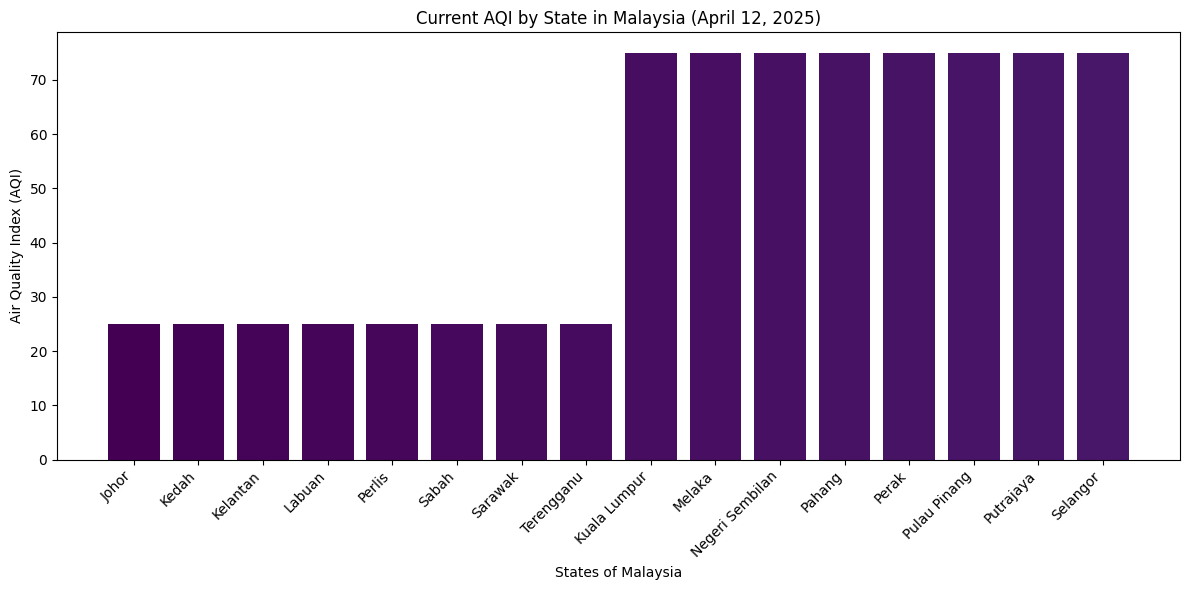

In [57]:
# Data - Representing AQI categories with numerical values for visualization
states = ['Johor', 'Kedah', 'Kelantan', 'Labuan', 'Perlis', 'Sabah', 'Sarawak', 'Terengganu',
          'Kuala Lumpur', 'Melaka', 'Negeri Sembilan', 'Pahang', 'Perak', 'Pulau Pinang', 'Putrajaya', 'Selangor']
aqi_values = [25, 25, 25, 25, 25, 25, 25, 25, 75, 75, 75, 75, 75, 75, 75, 75] # Assigning representative AQI values

# Sort the data by AQI values
sorted_data = sorted(zip(states, aqi_values), key=lambda x: x[1])
states_sorted = [x[0] for x in sorted_data]
aqi_values_sorted = [x[1] for x in sorted_data]

# Colors - Generate a list of distinct colors
num_states = len(states)
colors = plt.cm.viridis(range(num_states)) # Use a colormap for distinct colors

# Create the bar chart
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
bars = plt.bar(states_sorted, aqi_values_sorted, color=colors)

# Add labels and title
plt.xlabel('States of Malaysia')
plt.ylabel('Air Quality Index (AQI)')
plt.title('Current AQI by State in Malaysia (April 12, 2025)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Display the chart
plt.show()

It actually works! What a powerful agent it is!

Now let us view the logs to see the chat history.

In [54]:
view_logs()

---
[2025-04-12T19:08:47.068137] (text_with_grounding)
Input: Wow, that is such a complete answer! How about animals?
Output: Air pollution has significant negative impacts on animals, mirroring many of the effects seen in humans. Here's a breakdown of the key consequences:

**General Health Effects**

*   **Mortality:** Air pollution can lead to the death of sensitive animals.
*   **Organ Injury:** Exposure to air polluta...
Latency: 6.44s

---
[2025-04-12T19:08:17.690758] (text_with_grounding)
Input: Can I know the effects of air pollution to human health?
Output: Air pollution can have a wide range of negative effects on human health, both in the short term and over the long term. Here's a summary of the key health impacts:

**General Health Effects**

*   **Mortality:** Air pollution is associated with increased mortality rates.
*   **Inflammation and Oxida...
Latency: 5.33s

---
[2025-04-12T19:06:45.414891] (text_with_grounding)
Input: Nice, can I know about Tokyo too?
Output: The

There you have it! That's the bot, Robert that I built to provide the most updated, modern insights and suggestions about air pollution to the user. Any ideas on improving it do let me know! I will try to fine tune and make it even better😄

Made possible by: Wong Hoong Liang

Thanks Kaggle for the 5 day Intensive GenAI course so that I can build this project on my own, of course with some help from GenAI to help build the programs for this agent as well.😂

# **Contact Me!**

Let's connect!
https://www.linkedin.com/in/wong-hoong-liang-57124530a/

My Github (I will upload the codes for the course and this project):
https://github.com/RWong09